In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [4]:
numLayer = 4
numQubit = 2
global iterations
global noisy

In [5]:
#Create unitaries here
unitary_param_1 = np.array([])
for i in range(0, 16):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

In [6]:
print(unitary_param_1)

[3.1501167  0.29908748 4.95923623 2.57254176 2.34660663 6.19738228
 1.1895098  0.5466865  3.29268422 2.01713517 5.17127747 4.33059976
 3.90270397 3.93293429 0.87286833 1.90592691]


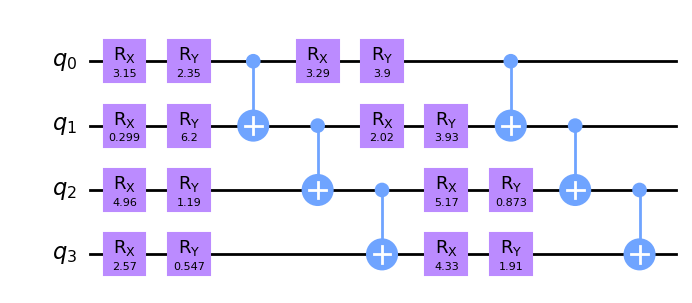

In [7]:
# First unitary
size = 4
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [8]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [9]:
def createEqSuperpos3BE():
    temp = QuantumCircuit(3)
    temp.ry(2*np.arctan(1/np.sqrt(2)), 0)
    temp.x(0)
    temp.ch(0, 1)
    temp.x(0)
    temp.h(2)
    return temp

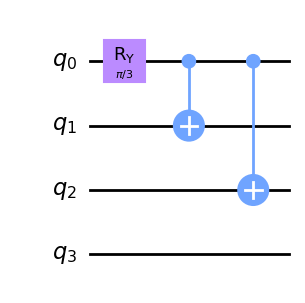

In [68]:
qcTest = QuantumCircuit(4)
qcTest.ry(np.pi/3, 0)
qcTest.cx(0, 1)
qcTest.cx(0, 2)
qcTest.draw('mpl')

In [69]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(7)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperpos3BE()
    circ.append(superPosCircuit, [0, 1, 2])

    circ.append(state, [3, 4, 5, 6])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [5, 6])
    
    circ.cswap(2, 5, 6)
    circ.cswap(1, 4, 6)
    circ.cswap(0, 4, 5)
    
    circ.append(superPosCircuit.inverse(), [0, 1, 2])
    
    return circ

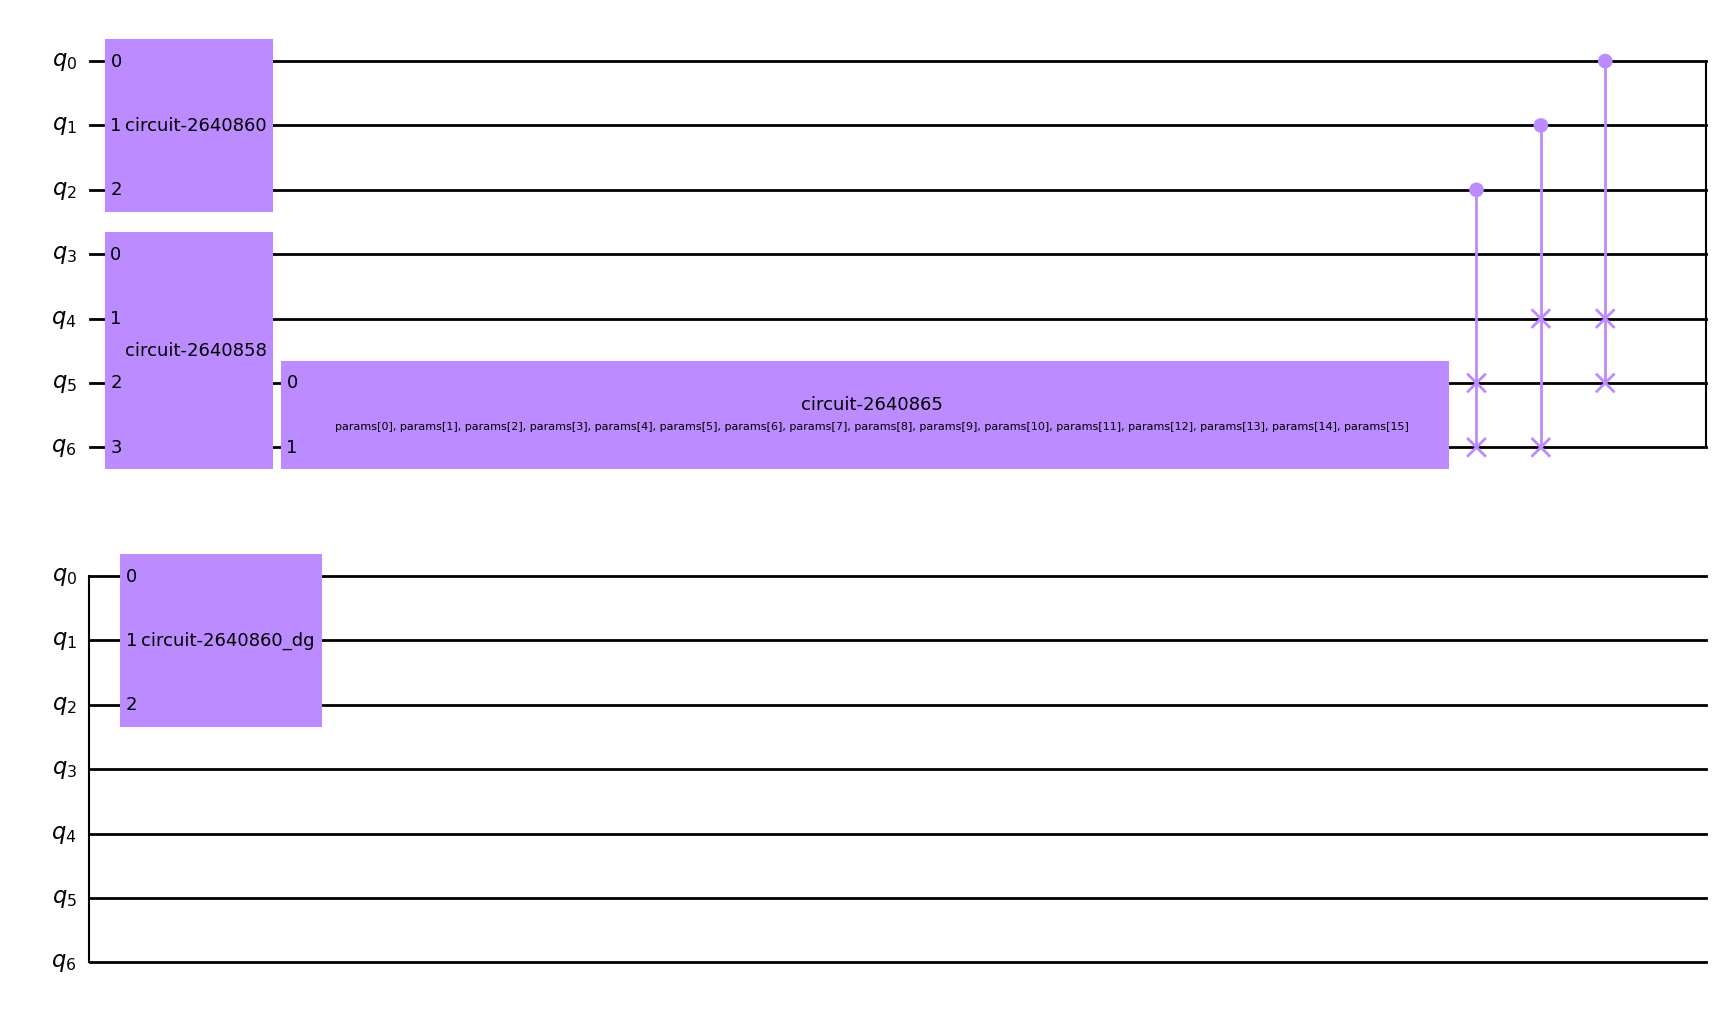

In [70]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [71]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [72]:
#Use if noisy
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [73]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [74]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [75]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [76]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15])])


In [77]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [78]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[5.88287828e+00 9.20429921e-01 6.05917613e+00 3.77567615e+00
 4.76978716e+00 3.78131737e+00 1.02476429e+00 1.95669920e+00
 3.54923047e+00 1.25000229e-02 1.61320509e+00 4.11273960e+00
 3.85061631e-03 6.02478513e+00 1.03747721e+00 4.01549373e+00]
Initial Cost :  0.5038549988051135


In [80]:
true_value = 1.0

In [81]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.5038549988051135
Loss Value :  0.3794772326855505 1.0%
Loss Value :  0.48040406578405515 2.0%
Loss Value :  0.5315919133475088 3.0%
Loss Value :  0.4869126213772877 4.0%
Loss Value :  0.486604439005256 5.0%
Loss Value :  0.48673705669042944 6.0%
Loss Value :  0.5082931318794439 7.0%
Loss Value :  0.5990950040220904 8.0%
Loss Value :  0.6221627225993194 9.0%
Loss Value :  0.6224782159126857 10.0%
Loss Value :  0.6452699166116737 11.0%
Loss Value :  0.646669097497796 12.0%
Loss Value :  0.6720925413792074 13.0%
Loss Value :  0.6802751319654464 14.0%
Loss Value :  0.6806796751906266 15.0%
Loss Value :  0.6809987283359051 16.0%
Loss Value :  0.8373092979191255 17.0%
Loss Value :  0.9211191904067924 18.0%
Loss Value :  0.9250809886947904 19.0%
Loss Value :  0.9257210608305777 20.0%
Loss Value :  0.9250361051885394 21.0%
Loss Value :  0.9245291054177981 22.0%
Loss Value :  0.9420598581979833 23.0%
Loss Value :  0.9264688811734787 24.0%
Loss Value :  0.9527682135670887 25.0%

In [82]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.45562309261579403
Loss Value :  0.3917423723631781 1.0%
Loss Value :  0.434321922670655 2.0%
Loss Value :  0.5567568216786021 3.0%
Loss Value :  0.5810744472696031 4.0%
Loss Value :  0.5712588859728757 5.0%
Loss Value :  0.612483718549077 6.0%
Loss Value :  0.6521535602612798 7.0%
Loss Value :  0.6379432955112444 8.0%
Loss Value :  0.6240121236306462 9.0%
Loss Value :  0.7041489870016692 10.0%
Loss Value :  0.6839140902887042 11.0%
Loss Value :  0.6818155330942393 12.0%
Loss Value :  0.7677437912872943 13.0%
Loss Value :  0.7774958331159825 14.0%
Loss Value :  0.729337567449957 15.0%
Loss Value :  0.7717402897444293 16.0%
Loss Value :  0.7040329527736292 17.0%
Loss Value :  0.7280634910518673 18.0%
Loss Value :  0.731948953277972 19.0%
Loss Value :  0.7143743704348128 20.0%
Loss Value :  0.7624306376038511 21.0%
Loss Value :  0.6059250021555899 22.0%
Loss Value :  0.7059055809523239 23.0%
Loss Value :  0.6919342733885047 24.0%
Loss Value :  0.7600228324242415 25.0%
Lo

In [83]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.9850960055016332


In [84]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  1.0
Noiseless :  0.999435841266062
Noisy :  0.8403329865967987
Noise Resilient Value :  0.9850960055016332


In [85]:
def writeToFile():
    file = open("S3_GBSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [86]:
writeToFile()